# tSANE on TF
density low <=> sigma big => entropy big => perplexity big
 
 https://github.com/maestrojeong/t-SNE
 

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tensorflow.examples.tutorials.mnist import input_data
from IPython.display import clear_output
%matplotlib inline

## Parameters

In [15]:
ndata = 300 # 3000
image_size = 784

## Dataset

In [3]:
mnist = input_data.read_data_sets('/tmp/MNIST_data', one_hot=True)
train = {}
train['image'] = mnist.train.images[:ndata]
train['label'] = mnist.train.labels[:ndata]

Extracting /tmp/MNIST_data/train-images-idx3-ubyte.gz
Extracting /tmp/MNIST_data/train-labels-idx1-ubyte.gz
Extracting /tmp/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting /tmp/MNIST_data/t10k-labels-idx1-ubyte.gz


## t-SNE

In [4]:
def normalize(array):
    '''
    normalize for 1D array
    '''
    return array/np.sum(array)

def get_entropy(array):
    '''
    Calculate entropy for 1D array
    '''
    if np.sum(array) !=1:
        array = normalize(array)
        
    sum_ = 0
    length = len(array)
    for i in range(length):
        if array[i]!=0:
            sum_+=array[i]*np.log2(array[i])
    return -sum_

def get_prob(sigma_1d):
    '''
    prob[i][j] = p_{j|i}
    '''
    prob = np.zeros([ndata, ndata])
    for i in range(ndata):
        for j in range(ndata):
            prob[i][j] = np.exp(-sq_dist[i][j]/2/sigma_1d[i]/sigma_1d[i])
    
    #diagonal should be 0
    for i in range(ndata):
        prob[i][i] = 0 
    
    for i in range(ndata):
        prob[i] = normalize(prob[i])
    
    return prob

def get_prob_1d(row, sigma):
    '''
    prob[i][j] = p_{j|i}
    return prob[i]
    '''
    prob = np.zeros(ndata)
    for j in range(ndata):
        prob[j] = np.exp(-sq_dist[row][j]/2/sigma/sigma)
    
    #diagonal should be 0
    prob[row] = 0 
    
    return normalize(prob)


def get_perp(entropy):
    return np.power(2, entropy)

def get_shape(tensor):
    return tensor.get_shape().as_list()

def t_sne(y):
    '''
    Arg :
        y - 2D tensor [ndata, nmap]
    '''
    batch, nmap = get_shape(y)
    y_tr = tf.transpose(y)
    y_mapped = []
    for i in range(nmap):
        y_mapped.append(tf.transpose([y_tr[i]])-y_tr[i])
    y_square = 0
    for i in range(nmap):
        y_square+= tf.square(y_mapped[i])
    y_add = y_square+1
    y_div = tf.div(1., y_add)
    y_mask = y_div*(1-tf.eye(batch))
    y_sum = tf.reduce_sum(y_mask)
    y_normalize = y_mask/y_sum
    cost = -tf.reduce_mean(joint_prob*tf.log(clip(y_normalize)))
    return cost

def clip(x, vmax = 1-1e-10, vmin = 1e-10):
    return tf.clip_by_value(x, clip_value_max=vmax, clip_value_min=vmin)

### Compute distances

In [5]:
%%time
sq_dist= np.zeros([ndata, ndata])
for i in range(ndata):
    clear_output(True)
    print(i)
    for j in range(ndata):
        sq_dist[i][j] = np.sum(np.square(train['image'][i]-train['image'][j]))
clear_output(True)
print('Done.')

Done.
CPU times: user 2.47 s, sys: 396 ms, total: 2.86 s
Wall time: 2.46 s


### Compute probabilities

In [8]:
%%time

sigma = np.ones(ndata)

max_try = 2000
boundary = 1
perp = 20

for i in range(ndata):
    smax = np.max(sq_dist)
    smin = np.min(sq_dist)
    cur_perp = get_perp(get_entropy(get_prob_1d(i, sigma[i])))
    trial = 0
    perp_diff = np.abs(perp - cur_perp)
    clear_output(True)
    print(i)
    while perp_diff > boundary and trial < max_try:
        trial+=1
        if perp>cur_perp:
            smin = sigma[i]
            sigma[i] = (sigma[i]+smax)/2
        else: 
            smax = sigma[i]
            sigma[i] = (sigma[i]+smin)/2
        cur_perp = get_perp(get_entropy(get_prob_1d(i, sigma[i])))
        perp_diff = np.abs(perp - cur_perp)
        
prob = get_prob(sigma)
joint_prob = np.zeros((ndata, ndata))
for i in range(ndata):
    for j in range(ndata):
        joint_prob[i][j]=(prob[i][j]+prob[j][i])/2/ndata
        
clear_output(True)
print('Done.')

Done.
CPU times: user 17.4 s, sys: 240 ms, total: 17.6 s
Wall time: 17.4 s


## Visual routines

In [27]:
def PlotEmbedding3d(dataset, npoint=500, shift=0, title=None):
    mapped = sess.run(embeds, feed_dict = {x : dataset.images[shift:shift+ndata]})
    mapped = mapped[:npoint]
    fig = plt.figure(figsize=(10,10))
    
    ax = fig.gca(projection='3d')
    colors = [np.argmax(dataset.labels[shift+i]) for i in range(len(mapped))]
    ax.scatter(*zip(*mapped), c=colors, s=100)
    if title:
        plt.title(title)

## Network

In [17]:
def Perceptron(inputs, out_dim):
    
    l = inputs
    l = tf.layers.dense(l, units=500, activation=tf.nn.relu)
    l = tf.layers.dense(l, units=1000, activation=tf.nn.relu)
    l = tf.layers.dense(l, units=2000, activation=tf.nn.relu)
    l = tf.layers.dense(l, units=out_dim)
    
    outputs = l
    
    return outputs

In [18]:
x = tf.placeholder(dtype = tf.float32, shape = [ndata, image_size], name = 'image')

with tf.device("/gpu:0"):
    embeds = Perceptron(inputs=x, out_dim=3)
cost = t_sne(embeds)*10000
run_train = tf.train.AdamOptimizer(3e-4).minimize(cost)

### Train

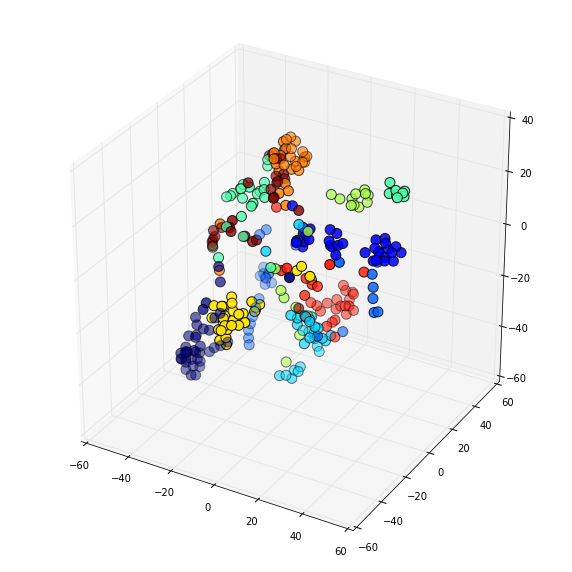

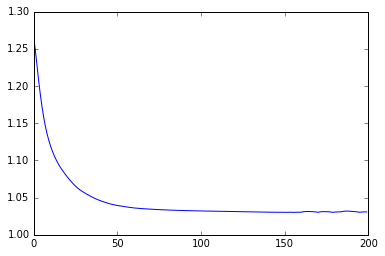

Step: 200/200, Cost: 1.03e+00
CPU times: user 11.9 s, sys: 3.7 s, total: 15.6 s
Wall time: 11.1 s


In [34]:
%%time
train_steps = 200
log_every = 10

cost_tract = []
sess= tf.Session()
sess.run(tf.global_variables_initializer())

try:
    for step in range(train_steps):
        _, c = sess.run([run_train, cost], feed_dict={x : train['image']})
        cost_tract.append(c)
        if step%log_every == log_every - 1:
            progress = "Step: %d/%d, Cost: %.2e" % (step+1, train_steps, c)
            PlotEmbedding3d(mnist.train, title=progress, npoint=500)
            clear_output(True)
            plt.show()            
except KeyboardInterrupt:
    pass
clear_output(True)
PlotEmbedding3d(mnist.train, npoint=500);
plt.show()
plt.plot(cost_tract)
plt.show()
print(progress)

### Validate

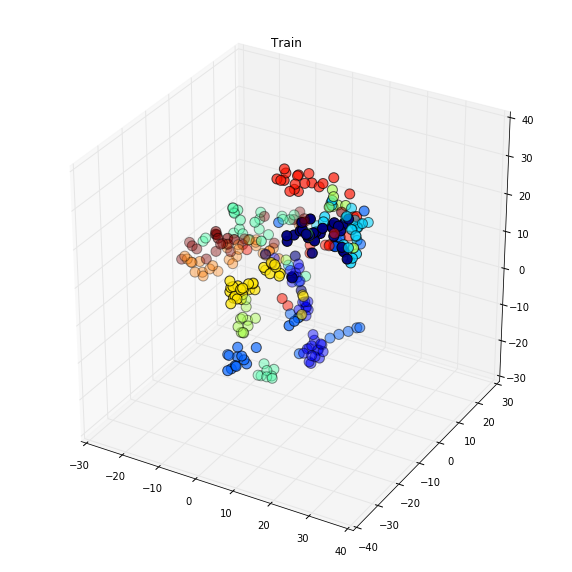

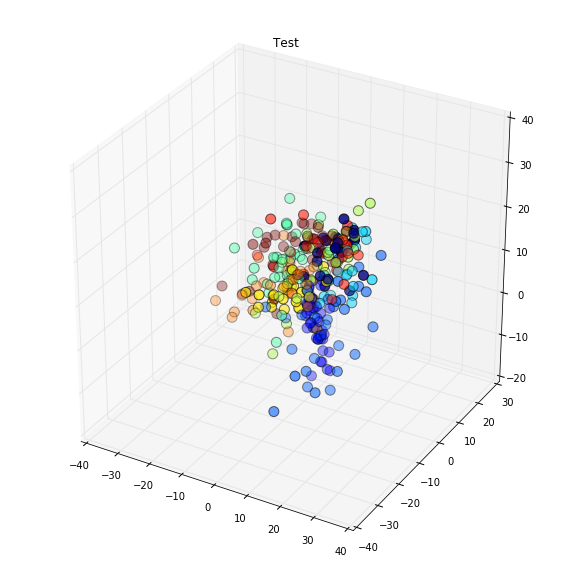

In [29]:
PlotEmbedding3d(mnist.train, 2000, title = "Train")
plt.show()
PlotEmbedding3d(mnist.test, 2000, title = "Test")
plt.show()